# Desafio Manutenção Preditiva

Por: Gustavo Perbone

In [1]:
# descomente e rode o comando abaixo para instalar os pacotes necessários!
# pip install -r requirements.txt

Na célula abaixo estarão concentrados todos os imports necessários para o projeto. 

In [2]:
# imports

# data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# preparation for creatig the models
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# improving model parameters
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## 1. Importando os dados

Como primeiro passo, vamos importar os dados de treino e explorá-los.

In [3]:
df_falhas = pd.read_csv('data/desafio_manutencao_preditiva_treino.csv')
display(df_falhas.head())
print(f'A tabela tem {df_falhas.shape[1]} colunas e {df_falhas.shape[0]} registros.')

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


A tabela tem 9 colunas e 6667 registros.


Dos dados fornecidos previamente nas instruções, sabemos que as seguintes colunas estão presentes no dataset:
- **udi**: é o identificador único de cada registro, indo de 1 a 10000;
- **product id**: consiste na letra L, M, H e um número serial específico da variante;
- **type**: é o primeiro caracter do *product_id*, significando a qualidade da variante do produto: L(50% dos produtos), M(30% dos produtos) ou H(20%);
- **air temperature [K]**: gerada utilizando o método de passeio aleatório e posteriormente normalizada com um desvio padrão de 2 K em torno de 300 K;
- **process temperature [K]**: gerada utilizando o método de passeio aleatório e posteriormente normalizada com um desvio padrão de 1 K, adicionada a temperatura do ar mais 10 K;
- **rotational speed [rpm]**: calculada em torno de uma potência de 2860 W, sobreposta com um ruído de distribuição normal;
- **torque [Nm]**: os valores de torque se referem a uma distribuição normal em torno de 40 Nm com DP= 10 Nm e sem valores negativos;
- **tool wear [min]**: A qualidade das variantes H/M/L adivionam 5/3/2 minutos de desgaste à ferramenta utilizada no processo. 
- **failure type**: representa se houve falha no processo. Pode ser *No Failure* (sem falha), *tool wear failure (TWF)*, *heat dissipation failure (HDF)*, *power failure (PWF)*, *overstrain failure (OSF)* ou *random failures (RNF)*.

Os tipos  de falhas (failure type) que podem ocorer são:
- **tool wear failure (TWF)**: A ferramenta será reposta em um tempo de desgaste entre 200-240 min;
- **heat dissipation failure (HDF)**: A dissipação de calor causa uma falha no processo se a diferença entre a temperatura do ar e do processo for abaixo de 8.6K e a velocidade rotacional é abaixo de 1380 rpm;
- **power failure (PWF)**: o produto do torque e da velocidade rotacional (em rad/s) representa a potência requerida pelo processo. Se a potência for menor que 3500 W ou maior que 9000 W, o processo falha;
- **overstrain failure (OSF)**: se o produto de desgaste da ferramenta e torque exceder 11000 minNm para a variante L, 12000 para M ou 13000 para H, o processo falha;
- **random failures (RNF)**: cada processo tem chance de 0,1 % de falha, independente dos parâmetros.


Percebe-se que várias condições já são dadas para a ocorrência das falhas, e isso pode ser uma dica de quais features podemos criar para ajudar o nosso modelo durante a etapa de *feature engineering*!<br/> Isso também significa que não é possível prever as falhas aleatórias, já que como a prórpia descrição da variável nos diz, ela ocorre aleatoriamente. Por isso, as linhas que resultam em falhas aleatórias serão desconsideradas, e é possível esperar uma performance ruim para essa categoria. No entanto, como vimos acima, ela representa apenas 0,1% das falhas.

In [4]:
df_falhas.shape

(6667, 9)

In [5]:
df_falhas = df_falhas[df_falhas.failure_type != 'Random Failures']
print(f'Restaram {df_falhas.shape[0]} colunas! Foram excluídas {((6667-df_falhas.shape[0])*100/6667):.2f}% das colunas')

Restaram 6655 colunas! Foram excluídas 0.18% das colunas


In [6]:
# Verificando se há valores vazios e os tipos
df_falhas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6655 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6655 non-null   int64  
 1   product_id             6655 non-null   object 
 2   type                   6655 non-null   object 
 3   air_temperature_k      6655 non-null   float64
 4   process_temperature_k  6655 non-null   float64
 5   rotational_speed_rpm   6655 non-null   int64  
 6   torque_nm              6655 non-null   float64
 7   tool_wear_min          6655 non-null   int64  
 8   failure_type           6655 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 519.9+ KB


In [7]:
# Verificando a quantidade de valores únicos por coluna
df_falhas.nunique()

udi                      6655
product_id               6655
type                        3
air_temperature_k          93
process_temperature_k      82
rotational_speed_rpm      840
torque_nm                 547
tool_wear_min             243
failure_type                5
dtype: int64

Podemos concluir que não há valores vazios no dataset de treino. Também é possível concluir que as colunas *udi* e *product_id* são exclusivas de cada linha, então elas não serão úteis para o modelo. Podemos removê-las:

In [8]:
df_falhas.drop(["udi", "product_id"], axis = 1, inplace=True)
df_falhas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6655 entries, 0 to 6666
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   6655 non-null   object 
 1   air_temperature_k      6655 non-null   float64
 2   process_temperature_k  6655 non-null   float64
 3   rotational_speed_rpm   6655 non-null   int64  
 4   torque_nm              6655 non-null   float64
 5   tool_wear_min          6655 non-null   int64  
 6   failure_type           6655 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 415.9+ KB


Por fim, temos 1 feature do tipo object e 5 features do tipo numéricas, sendo 3 float e 2 inteiras. O target é um object.
<br/>
Abaixo faremos a exploração destes dados.

## 2. Análise Exploratória dos Dados

Agora podemos explorar os dados que temos disponíveis para criação do modelo, para entender suas distribuições, se há outliers, e se há alguma vairável que precisa ser transformada.

In [9]:
df_falhas.describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6655.000000,6655.000000,6655.000000,6655.000000,6655.000000
mean,299.991255,309.991360,1537.500676,40.052111,108.079189
std,1.994807,1.487567,177.277403,9.948498,63.336292
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,54.000000
50%,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,251.000000


### Target

Vamos verificar a distribuição do target:

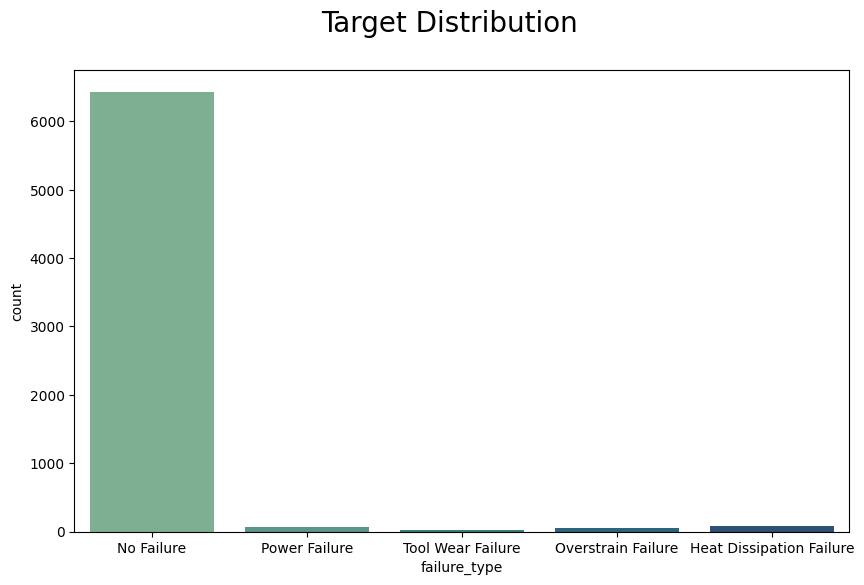

In [10]:
fig= plt.subplots(figsize=(10,6))
sns.countplot(data=df_falhas, x='failure_type', palette = 'crest')

plt.suptitle('Target Distribution', fontsize=20)
plt.show()

In [11]:
print("Tipo de Falha")
print(df_falhas.failure_type.value_counts(normalize=True))

Tipo de Falha
No Failure                  0.966942
Heat Dissipation Failure    0.011270
Power Failure               0.009467
Overstrain Failure          0.007814
Tool Wear Failure           0.004508
Name: failure_type, dtype: float64


Conclusões:
- **target**: apenas 3,5% dos dados são falhas. Isso precisará ser balanceado antes do treinamento dos modelos de classificação. Além disso, a variável deverá ser convertida em numérica.

### Variáveis Categóricas

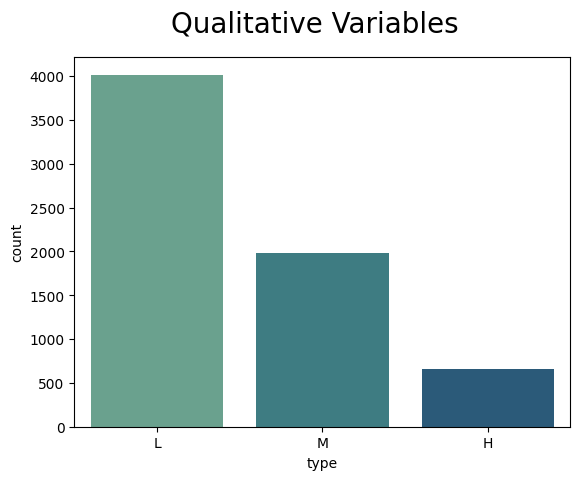

In [12]:
sns.countplot(data=df_falhas, x='type', palette = 'crest', order=['L', 'M', 'H'])

plt.suptitle('Qualitative Variables', fontsize=20)
plt.show()

In [13]:
print("Tipo de qualidade")
print(df_falhas.type.value_counts(normalize=True))

Tipo de qualidade
L    0.603306
M    0.298422
H    0.098272
Name: type, dtype: float64


Iniciando pelas **variáveis qualitativas**, temos que:
- **type**: a maioria dos produtos é da variante L (60%), seguido por M (30%) e H (10%). Esta é uma variável categórica ordinal, que deverá ser transformada em númerica antes do treinamento de modelo, sem perder informações..

### Variáveis Quantitativas

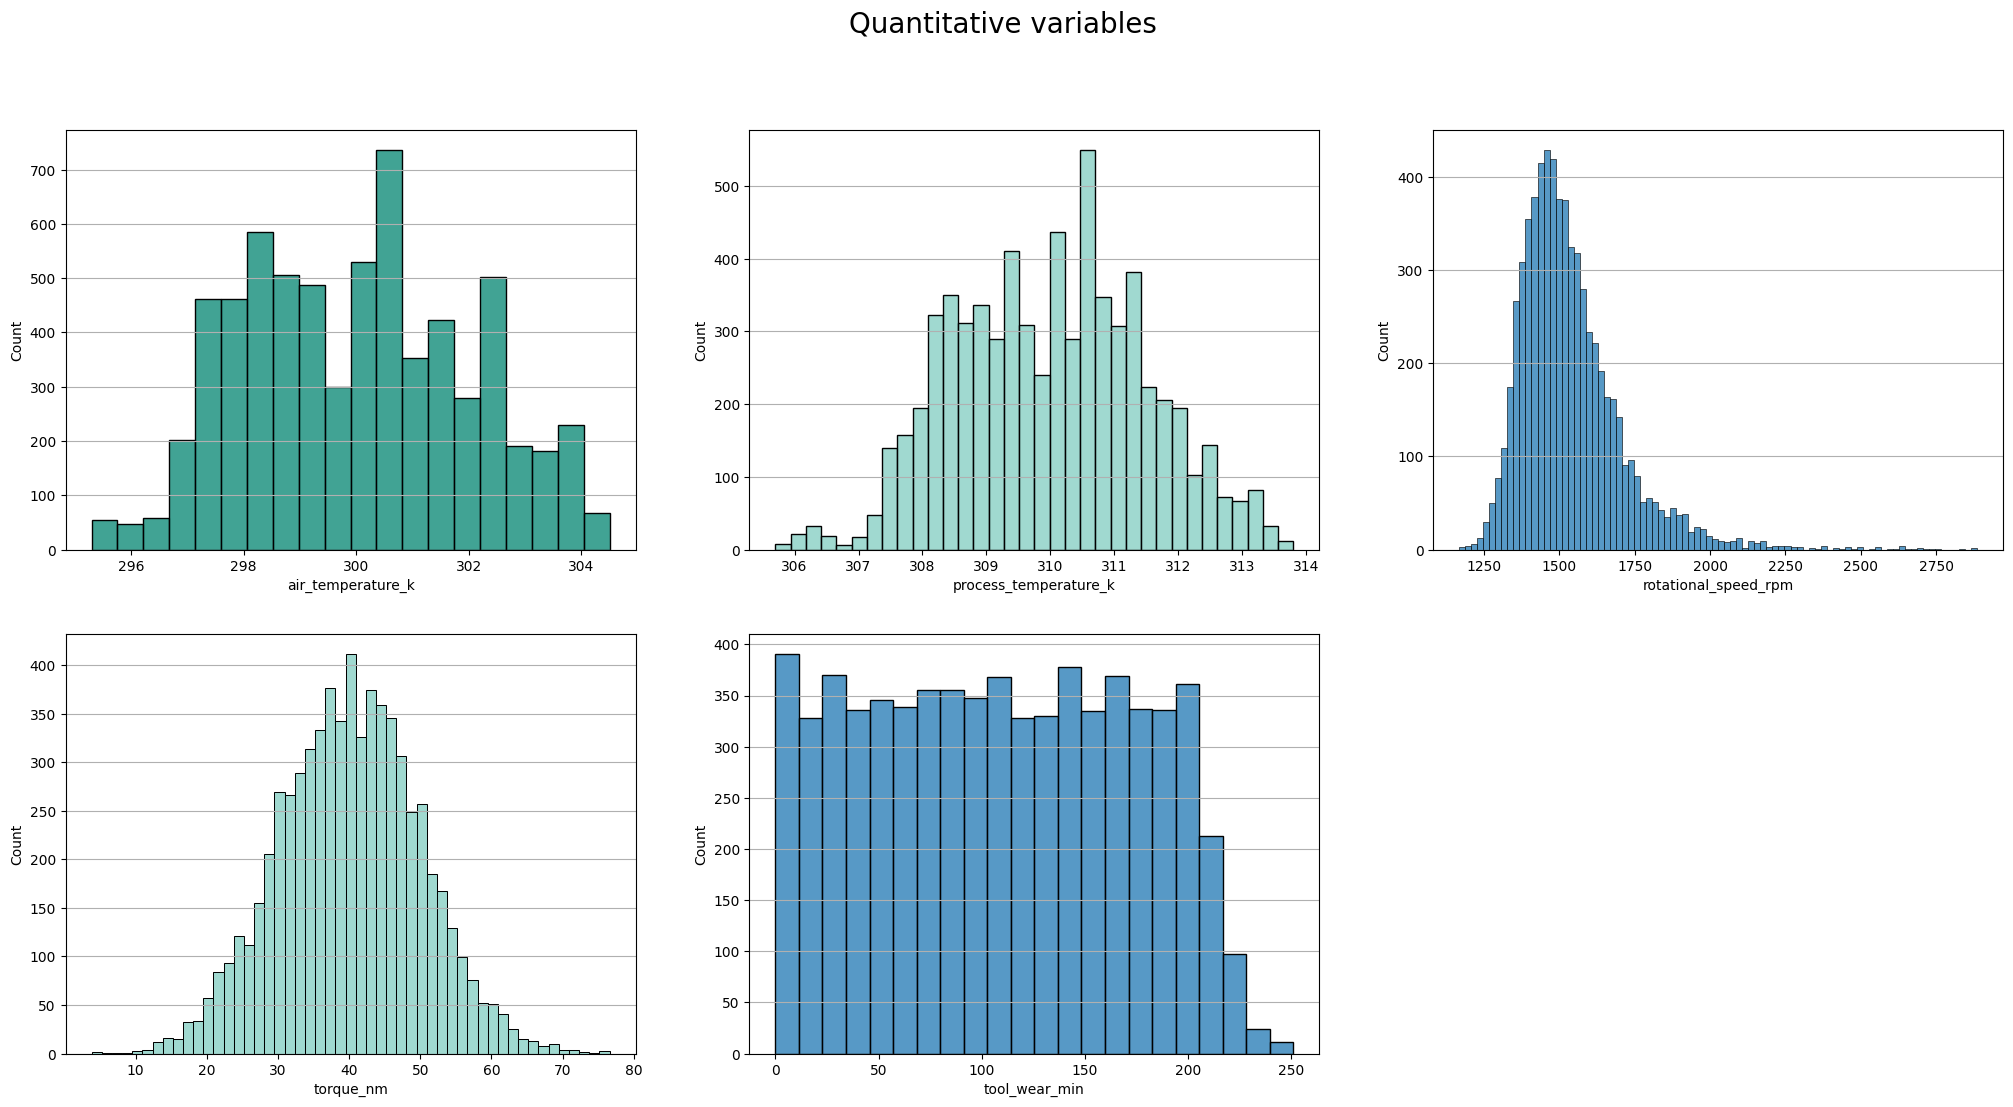

In [14]:
fig, ax = plt.subplots(2,3, figsize=(25,12))

sns.histplot(data=df_falhas, x='air_temperature_k', color='#018571', bins=20, ax=ax[0,0])
ax[0,0].grid(axis='y')

sns.histplot(data=df_falhas, x='process_temperature_k', color='#80cdc1', ax=ax[0,1])
ax[0,1].grid(axis='y')

sns.histplot(data=df_falhas, x='rotational_speed_rpm', palette = '#018571', ax=ax[0,2])
ax[0,2].grid(axis='y')

sns.histplot(data=df_falhas, x='torque_nm', color='#80cdc1', ax=ax[1,0])
ax[1,0].grid(axis='y')

sns.histplot(data=df_falhas, x='tool_wear_min', palette = '#018571', ax=ax[1,1])
ax[1,1].grid(axis='y')

fig.delaxes(ax[1,2])

plt.suptitle('Quantitative variables', fontsize=20)
plt.show()

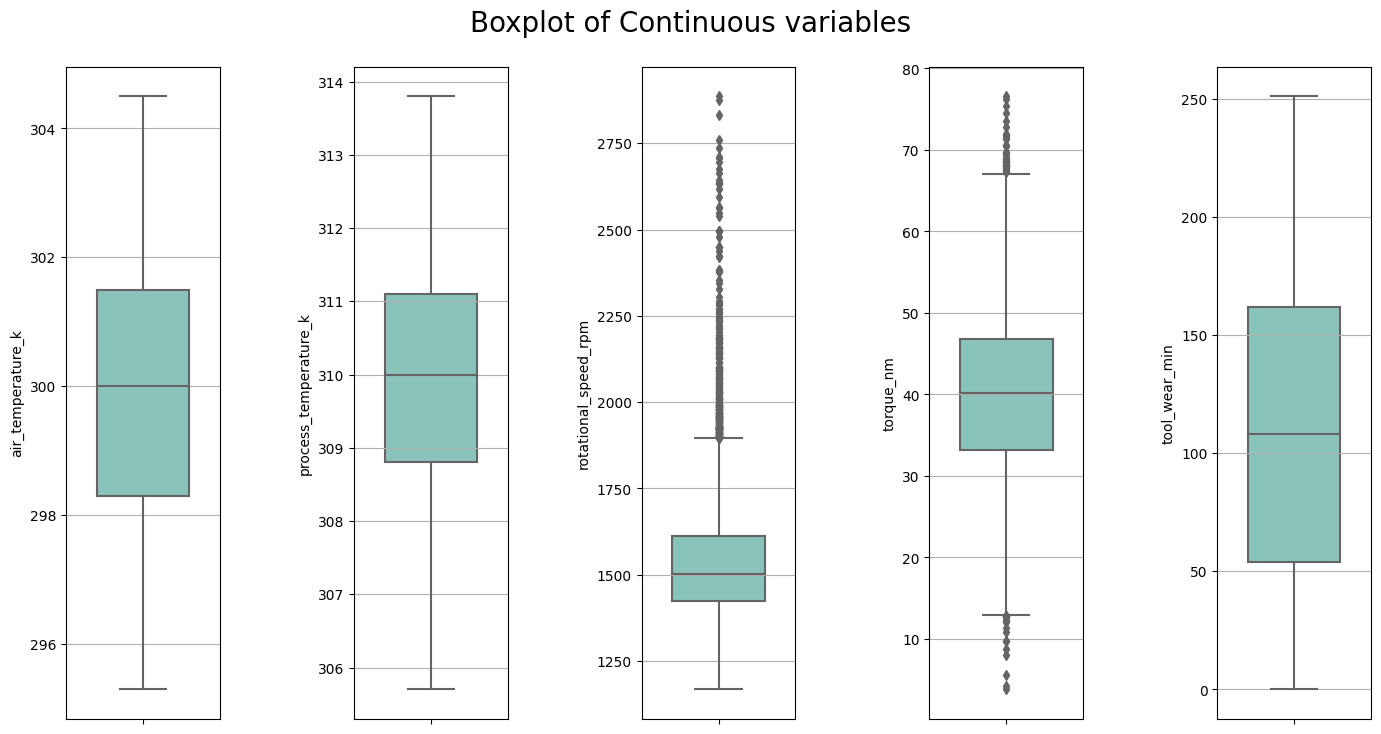

In [15]:
fig, ax = plt.subplots(1,5, figsize=(15,8))

sns.boxplot(ax=ax[0],y=df_falhas['air_temperature_k'], color='#80cdc1',width=0.6)
ax[0].grid(axis='y')

sns.boxplot(ax=ax[1],y=df_falhas['process_temperature_k'], color='#80cdc1',width=0.6)
ax[1].grid(axis='y')

sns.boxplot(ax=ax[2],y=df_falhas['rotational_speed_rpm'], color='#80cdc1',width=0.6)
ax[2].grid(axis='y')

sns.boxplot(ax=ax[3],y=df_falhas['torque_nm'], color='#80cdc1',width=0.6)
ax[3].grid(axis='y')

sns.boxplot(ax=ax[4],y=df_falhas['tool_wear_min'], color='#80cdc1',width=0.6)
ax[4].grid(axis='y')

fig.tight_layout(pad=5.0)
plt.suptitle('Boxplot of Continuous variables', fontsize=20)
plt.show()

Em relação às variáveis **quantitativas**, temos que:
- **air_temperature_K**: segue uma distribuição que aparenta ser normal, mas não é perfeita. A média é 300K com DP de 2 K, sendo mínimo valor 295.3 K e o máximo 304.5 K;
- **process_temperature_k**: também segue uma distribuição próxima da normal, mas não é perfeita. A média é 310 K com DP de 1.49 K, sendo mínimo valor 305.7 K e o máximo 313.8 K;
- **rotational_speed_rpm**: tem uma distribuição assimétrica, com distribuição concentrada na esquerda e cauda longa à direita;
- **torque_nm**: tem uma distribuição normal, com média 40.05 Nm e DP 9.95 Nm;
- **tool_wear_min**: tem uma distribuição que se assemelha à uniforme, entre os valores mínimo e máximo (0 min e 251 min).

Além disso, pelo boxplot e também pela descrição numérica das variáveis, levanta-se a suspeita de outliers nos dados para as colunas de *rotational_speed_rpm* e *torque_nm*. Vamos manter isso em mente, mas não removeremos os outliers, já que como se trata de um dataset sobre falhas em máquinas, uma alta rotação que poderia ser considerado um outlier, por exemplo, **pode ser justamente a causa de uma falha**!

Agora que já conhecemos as variáveis, vamos ver como elas se relacionam entre si.

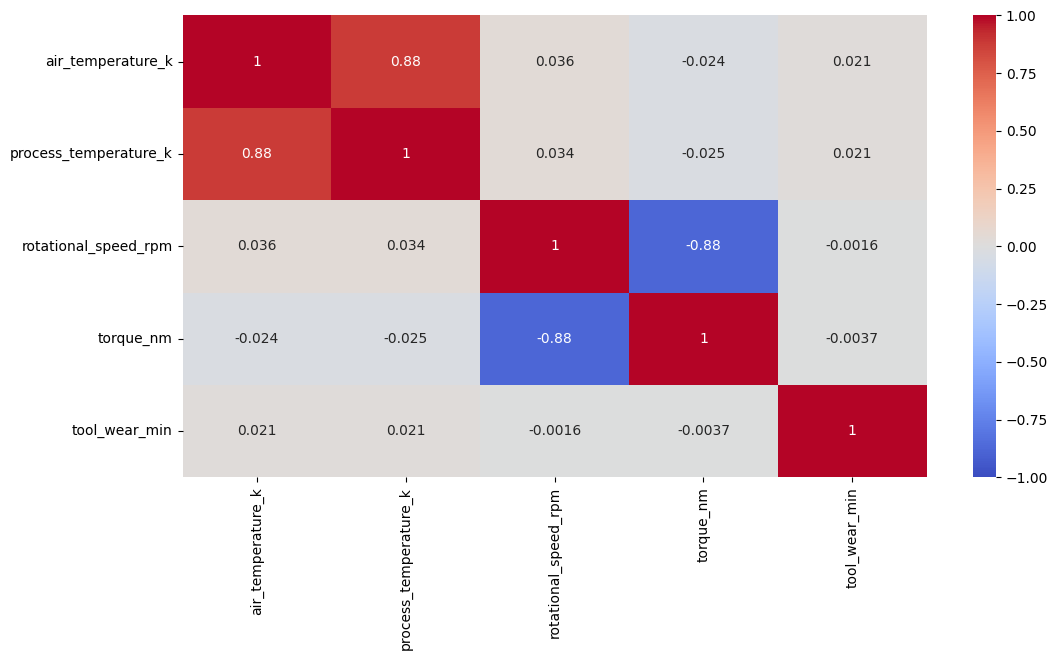

In [16]:
plt.figure(figsize=(12, 6))

sns.heatmap(df_falhas.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1);

Verifica-se que há uma correlação positiva entre *air_temperature_K* e *process_temperature_K*, além de uma correlação negativa entre *torque_nm* e *rotational_speed_rpm*.<br/>

Vamos visualizar as distribuições dos dados em relação ao target e ver se encontramos algum detalhe interessante:

In [17]:
#transformando type em 0,1,2 para plotar o gráfico. Isso é feito pois estamos considerando essa variável como qualitativa ordinal
df_falhas.type.replace({'L':0, 'M':1, 'H':2}, inplace=True)


Vamos verificar se há diferenças nas distribuições das variáveis em relação ao target. Vamos verificar por meio de boxplots:

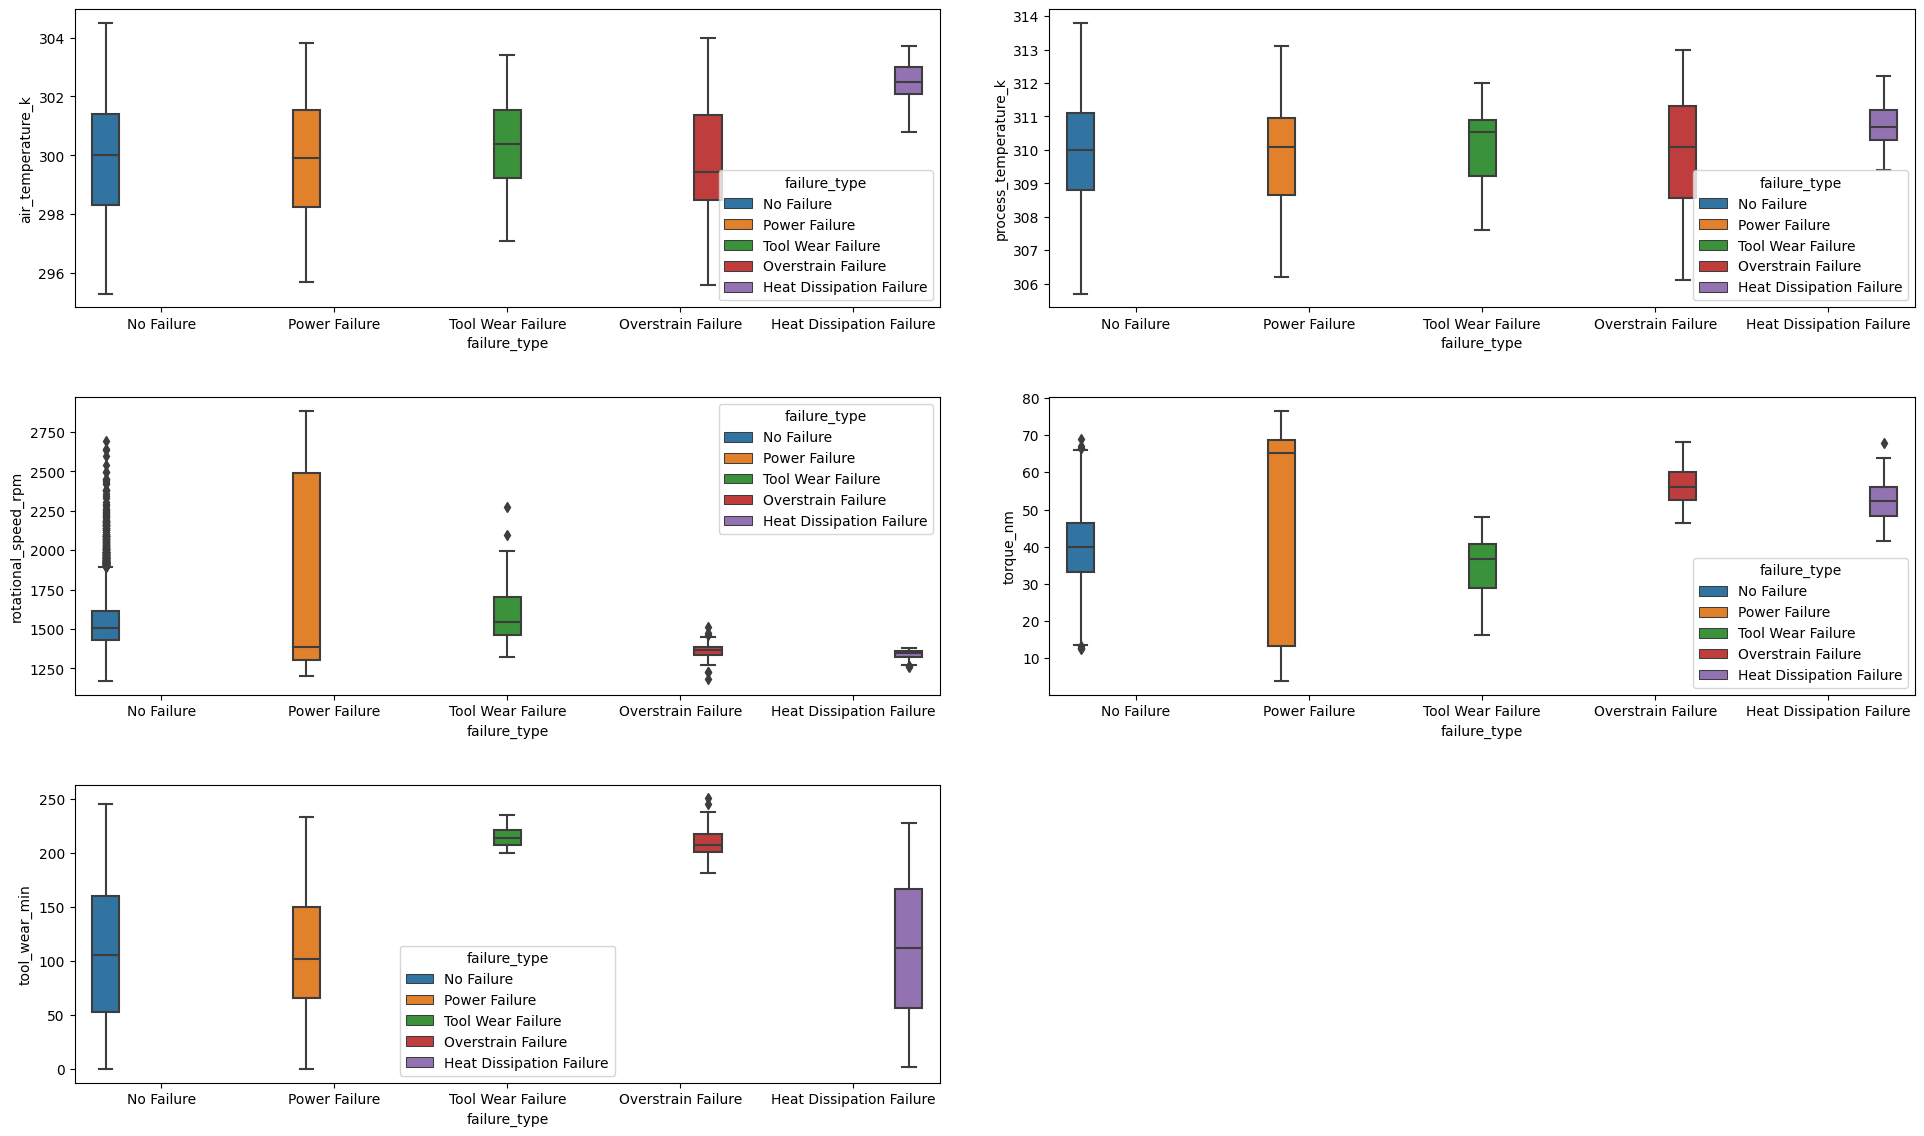

In [18]:
fig, ax = plt.subplots(3,2, figsize=(20,12))


sns.boxplot(data=df_falhas, y='air_temperature_k', x='failure_type',hue="failure_type", ax=ax[0,0])
sns.boxplot(data=df_falhas, y='process_temperature_k', x='failure_type',hue="failure_type", ax=ax[0,1])
sns.boxplot(data=df_falhas, y='rotational_speed_rpm', x='failure_type',hue="failure_type", ax=ax[1,0])
sns.boxplot(data=df_falhas, y='torque_nm', x='failure_type',hue="failure_type", ax=ax[1,1])
sns.boxplot(data=df_falhas, y='tool_wear_min', x='failure_type',hue="failure_type", ax=ax[2,0])

fig.delaxes(ax[2,1])

fig.tight_layout(pad=3.0)
plt.show()

É possível concluir que, de fato, as distribuições para as variáveis são diferentes entre quando há e quando não há falhas, e mesmo dependendo do tipo de falha.<br/> 
Isso indica que as variáveis que temos disponíveis podem ser o suficiente para gerar um bom **modelo de classificação**.

Os tipos  de falhas (failure type) que podem ocorer são:
- **tool wear failure (TWF)**: A ferramenta será reposta em um tempo de desgaste entre 200-240 min;
- **heat dissipation failure (HDF)**: A dissipação de calor causa uma falha no processo se a diferença entre a temperatura do ar e do processo for abaixo de 8.6K e a velocidade rotacional é abaixo de 1380 rpm;
- **power failure (PWF)**: o produto do torque e da velocidade rotacional (em rad/s) representa a potência requerida pelo processo. Se a potência for menor que 3500 W ou maior que 9000 W, o processo falha;
- **overstrain failure (OSF)**: se o produto de desgaste da ferramenta e torque exceder 11000 minNm para a variante L, 12000 para M ou 13000 para H, o processo falha;
- **random failures (RNF)**: cada processo tem chance de 0,1 % de falha, independente dos parâmetros.


# 3.Feature Engineering

Com base na descrição que tivemos inicialmente para cada um dos erros que podem acontecer, vamos criar algumas novas features para auxiliar e maximizar a performance o modelo:
- **is_time_for_change**: booleano representando se o tempo de desgaste se encontra entre 200 e 240 min (relacionado com a falha TWF);
- **temp_dif**: calcula a diferença entre a temperatura do ar e do processo (relacionado com a falha HDF);
- **power**: representa a potência, ou seja, torque multiplicado pela velocidade rotacional (relacionado com a falha PWF); 
- **overstrain**: produto do tempo de desgaste pelo torque (relacionado com a falha OSF).

In [19]:
df_falhas['is_time_for_change'] = df_falhas.apply(lambda x: 1 if (x.tool_wear_min > 200 and x.tool_wear_min < 240) else 0 ,axis=1)
df_falhas['temp_dif'] = df_falhas['process_temperature_k'] - df_falhas['air_temperature_k']
df_falhas['power'] = df_falhas['torque_nm'] * df_falhas['rotational_speed_rpm']
df_falhas['overstrain'] = df_falhas['torque_nm'] * df_falhas['tool_wear_min']

In [20]:
df_falhas.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,is_time_for_change,temp_dif,power,overstrain
0,1,298.1,308.6,1551,42.8,0,No Failure,0,10.5,66382.8,0.0
1,0,298.2,308.7,1408,46.3,3,No Failure,0,10.5,65190.4,138.9
2,0,298.2,308.7,1408,40.0,9,No Failure,0,10.5,56320.0,360.0
3,1,298.1,308.6,1425,41.9,11,No Failure,0,10.5,59707.5,460.9
4,0,298.1,308.6,1558,42.4,14,No Failure,0,10.5,66059.2,593.6


## 4.Pré-Processamento

Como comentado acima, este caso pede um **modelo de classificação**, pois dadas as features, o output do modelo deve ser a classificação do processo em um tipo específico de falha.

Vamos começar dividindo nosso dataset em treino e teste, para que não haja vazamento de dados, e transformando algumas features, lembrando que todas as alterações que forem feitas no dataset de treino devem ser refletidas no dataset de teste posteriormente.

- **type**: já foi transformado em uma coluna numérica (0,1,2);
- **air_temperature_K**: será padronizada usando StandardScaler;
- **process_temperature_k**: será padronizada StandardScaler;
- **rotational_speed_rpm**: como desconfiamos de alguns outliers nessa feature, utilizaremos o RobustScaler;
- **torque_nm**: como desconfiamos de alguns outliers nessa feature, utilizaremos o RobustScaler;
- **tool_wear_min**: por ter uma distribuição uniforme, usaremos MinMaxScaler;
- **is_time_for_change**: usaremos MinMaxScaler;
- **temp_dif**: usaremos MinMaxScaler;
- **power**: usaremos MinMaxScaler; 
- **overstrain**: usaremos MinMaxScaler;
- **failure_type**: será convertido em classes de 0 a 4

In [21]:
dict_falhas = {'No Failure':0, 'Power Failure':1, 'Tool Wear Failure':2, 'Overstrain Failure':3, 'Heat Dissipation Failure':4}
df_falhas.failure_type = df_falhas.failure_type.replace(dict_falhas)

In [22]:
# separando os dados para treino e teste, mas mantendo a estratificação de erros
df_train, df_test = train_test_split(df_falhas, train_size=0.8, random_state=42, stratify=df_falhas['failure_type'])

#separando as features e o failure_type
X_train = df_train.drop(columns=['failure_type'])
X_test = df_test.drop(columns=['failure_type'])

y_train = df_train['failure_type']
y_test = df_test['failure_type']

In [23]:
mms = MinMaxScaler()
rs = RobustScaler()
ss = StandardScaler()

mms_columns = ['tool_wear_min', 'is_time_for_change','temp_dif','power', 'overstrain']
rs_columns = ['rotational_speed_rpm', 'torque_nm']
ss_columns = ['air_temperature_k', 'process_temperature_k']

features_scaled_mms = pd.DataFrame(mms.fit_transform(X_train[mms_columns]))
features_scaled_rs = pd.DataFrame(rs.fit_transform(X_train[rs_columns]))
features_scaled_ss = pd.DataFrame(ss.fit_transform(X_train[ss_columns]))

In [24]:
# reconstruindo o dataset
X_train_scaled = pd.concat([features_scaled_mms,features_scaled_rs,features_scaled_ss], axis=1)
X_train_scaled = pd.concat([X_train_scaled,pd.DataFrame(X_train['type']).set_index(X_train_scaled.index)], axis = 1,ignore_index=True)
X_train_scaled.columns = ['tool_wear_min', 'is_time_for_change','temp_dif','power', 'overstrain', 'rotational_speed_rpm', 'torque_nm', 'air_temperature_k', 'process_temperature_k', 'type']

Faremos agora a transformação de dados para os dados de teste.

In [25]:
#neste caso, não fitamos os scalers novamente, apens transformamos os dados
features_scaled_mms = pd.DataFrame(mms.transform(X_test[mms_columns]))
features_scaled_rs = pd.DataFrame(rs.transform(X_test[rs_columns]))
features_scaled_ss = pd.DataFrame(ss.transform(X_test[ss_columns]))


In [26]:
# reconstruindo o dataset de teste
X_test_scaled = pd.concat([features_scaled_mms,features_scaled_rs,features_scaled_ss], axis=1)
X_test_scaled = pd.concat([X_test_scaled,pd.DataFrame(X_test['type']).set_index(X_test_scaled.index)], axis = 1,ignore_index=True)
X_test_scaled.columns = ['tool_wear_min', 'is_time_for_change','temp_dif','power', 'overstrain', 'rotational_speed_rpm', 'torque_nm', 'air_temperature_k', 'process_temperature_k', 'type']

Temos muito mais casos em que não há falhas do que casos em que há falhas, e isso pode influenciar negativamente o modelo. **Devemos balancear nossos dados!**<br/><br/>
Para tal, vamos usar o [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) (Synthetic Minority Over-sampling Technique), na qual são produzidas novas "observações sintéticas", ao contrário do que ocorreria com o RandomOverSampler, que simplesmente multiplica as ocorrências da classe minoritária. <br/>Basicamente, para realizar o seu trabalho o SMOTE pega pontos aleatórios da classe minoritária e encontra os K vizinhos mais próximos, selecionando posteriormente um desses e desenhando um vetor entre os dois pontos. Este vetor será utilizado para produzir o novo registro. Veja uma imagem ilustrativa abaixo.


<img src="https://imbalanced-learn.org/stable/_images/sphx_glr_plot_comparison_over_sampling_004.png" width=600>

In [27]:
# fazendo o balanceamento dos dados
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train_scaled, y_train)


print(f"Treino (antes): {X_train_scaled.shape}")
print(f"Treino: {X_sm.shape}")


Treino (antes): (5324, 10)
Treino: (25740, 10)


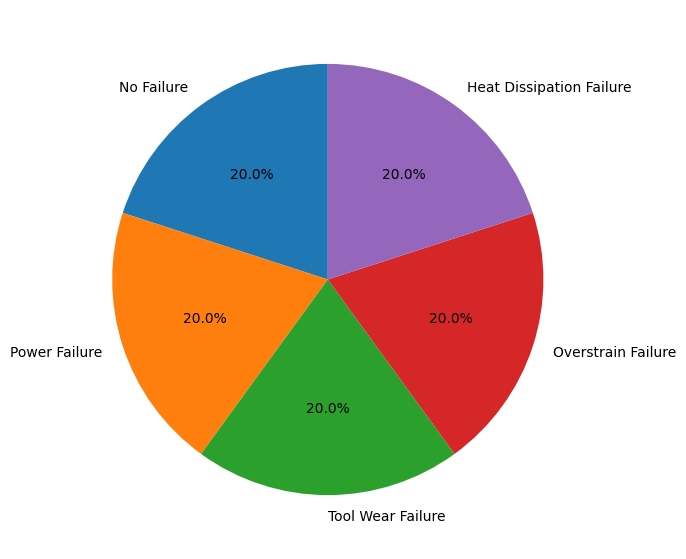

In [28]:
#conferindo o balanceamento das classes
df_sm = pd.concat([X_sm, y_sm], axis=1)
df_sm.columns = ['tool_wear_min', 'is_time_for_change','temp_dif','power', 'overstrain', 'rotational_speed_rpm', 'torque_nm', 'air_temperature_k', 'process_temperature_k', 'type', 'failure_type']
plt.figure(figsize = (7, 7))
plt.pie(x=df_sm.failure_type.value_counts(), labels={'No Failure':0, 'Power Failure':1, 'Tool Wear Failure':2, 'Overstrain Failure':3, 'Heat Dissipation Failure':4}, autopct='%1.1f%%', startangle=90)
plt.show()

# 5.Treinando os Modelos

Para este projeto, vamos utilizar três modelos de classificação: RandomForest, KNN e XGBoost. Após treiná-los, vamos comparar os resultados e escolher o que melhor se adaptou aos dados.

### Random Forest

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1287
           1       1.00      1.00      1.00        13
           2       0.19      0.67      0.30         6
           3       1.00      0.90      0.95        10
           4       0.88      0.93      0.90        15

    accuracy                           0.98      1331
   macro avg       0.81      0.90      0.83      1331
weighted avg       0.99      0.98      0.99      1331



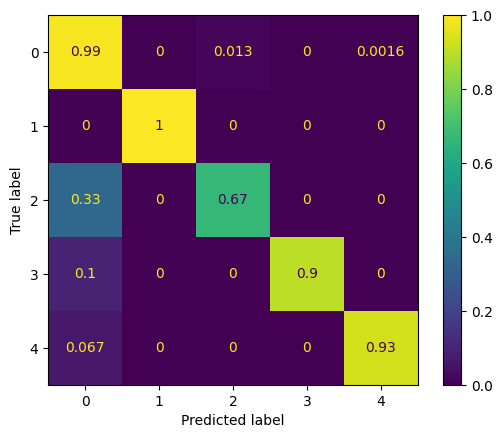

In [29]:
#criando e treinando o estimador baseline
estimador_rfc = RandomForestClassifier(random_state=42)
estimador_rfc.fit(X_sm, y_sm)
y_pred_rfc = estimador_rfc.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rfc))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rfc, normalize='true')).plot()

Um resultado considerável, porém ainda temos muitos erros que são preditos como "No Failure".

In [30]:
espaco_hiper = {
    'n_estimators': [10,100,200],
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth':[1, 15, 30],
    'max_leaf_nodes':[5, 15, 30]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

randomized_rfc = RandomizedSearchCV(
    estimator=estimador_rfc,
    param_distributions=espaco_hiper,
    cv=cv,
    scoring = 'f1_macro',
    verbose=3,
    random_state=42
)

randomized_rfc.fit(X_sm, y_sm)

y_pred = randomized_rfc.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

randomized_rfc.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=entropy, max_depth=1, max_leaf_nodes=15, n_estimators=10;, score=0.800 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=1, max_leaf_nodes=15, n_estimators=10;, score=0.805 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=1, max_leaf_nodes=15, n_estimators=10;, score=0.806 total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=1, max_leaf_nodes=15, n_estimators=10;, score=0.799 total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=1, max_leaf_nodes=15, n_estimators=10;, score=0.798 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_leaf_nodes=5, n_estimators=10;, score=0.843 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_leaf_nodes=5, n_estimators=10;, score=0.839 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_leaf_nodes=5, n_estimators=10;, score=0.845 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_l

{'n_estimators': 100,
 'max_leaf_nodes': 30,
 'max_depth': 15,
 'criterion': 'log_loss'}

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1287
           1       1.00      1.00      1.00        13
           2       0.08      1.00      0.15         6
           3       0.71      1.00      0.83        10
           4       0.83      1.00      0.91        15

    accuracy                           0.94      1331
   macro avg       0.73      0.99      0.77      1331
weighted avg       0.99      0.94      0.96      1331



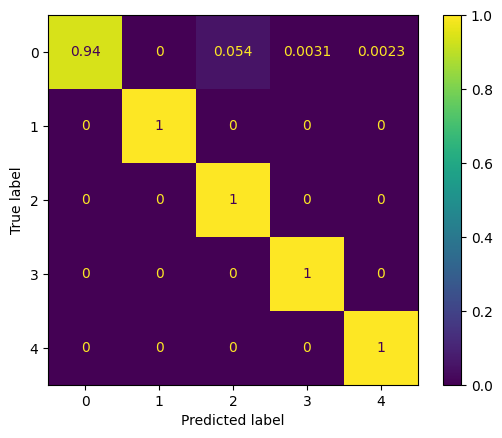

In [31]:
#treinando o estimador melhorado
estimador_rfc_best = RandomForestClassifier(random_state=42, n_estimators=100, max_leaf_nodes=30, max_depth=15, criterion='log_loss')
estimador_rfc_best.fit(X_sm, y_sm)
y_pred_rfc = estimador_rfc_best.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rfc))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rfc, normalize='true')).plot()

Este resultado é muito melhor, do que o anterior, pois o modelo não deixa de indicar nenhuma falha.<br/> Poderiamos dizer que este modelo é mais conservador, que é também o que desejamos quando queremos prevenir falhas, pois ao invés de classificar incorretamente as falhas como "No Failure", ele classifica algumas "No Failure" como falhas.

### KNN

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1287
           1       0.50      0.85      0.63        13
           2       0.10      0.83      0.18         6
           3       0.42      0.50      0.45        10
           4       0.40      0.80      0.53        15

    accuracy                           0.93      1331
   macro avg       0.48      0.78      0.55      1331
weighted avg       0.97      0.93      0.95      1331



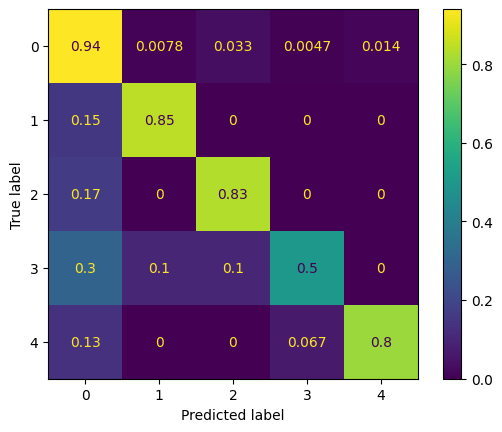

In [32]:
#criando e treinando o KNN baseline
estimador_knn = KNeighborsClassifier()
estimador_knn.fit(X_sm, y_sm)
y_pred_knn = estimador_knn.predict(X_test_scaled)

print(classification_report(y_test, y_pred_knn))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn, normalize='true')).plot()

In [33]:
espaco_hiper = {
    'n_neighbors': list(range(1,31)),
    'weights': ["uniform", "distance"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

randomized_knn = RandomizedSearchCV(
    estimator=estimador_knn,
    param_distributions=espaco_hiper,
    cv=cv,
    scoring = 'f1_macro',
    verbose=3,
    random_state=42
)

randomized_knn.fit(X_sm, y_sm)
randomized_knn.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.992 total time=   0.1s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.993 total time=   0.1s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.992 total time=   0.1s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.992 total time=   0.1s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.991 total time=   0.1s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.988 total time=   0.0s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.990 total time=   0.0s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.988 total time=   0.0s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.990 total time=   0.0s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.990 total time=   0.0s
[CV 1/5] END ...n_neighbors=19, weights=uniform;, score=0.977 total time=   0.1s
[CV 2/5] END ...n_neighbors=19, weights=uniform;

{'weights': 'uniform', 'n_neighbors': 1}

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1287
           1       0.50      0.62      0.55        13
           2       0.11      0.33      0.16         6
           3       0.50      0.40      0.44        10
           4       0.64      0.60      0.62        15

    accuracy                           0.96      1331
   macro avg       0.55      0.58      0.55      1331
weighted avg       0.97      0.96      0.96      1331



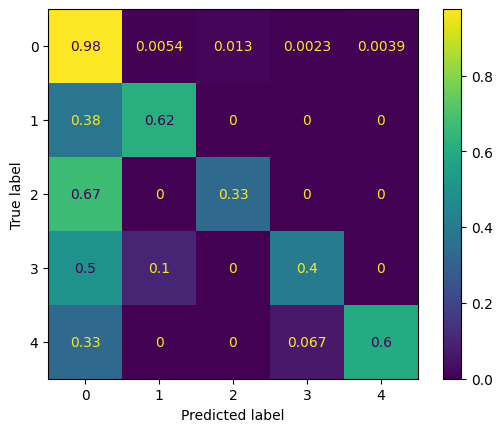

In [34]:
# treinando o KNN com melhores parâmetros
estimador_knn_best = KNeighborsClassifier(weights='uniform', n_neighbors= 1)
estimador_knn_best.fit(X_sm, y_sm)
y_pred_knn = estimador_knn_best.predict(X_test_scaled)

print(classification_report(y_test, y_pred_knn))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn, normalize='true')).plot()

### XGBoost

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1287
           1       1.00      1.00      1.00        13
           2       0.16      0.50      0.24         6
           3       1.00      0.90      0.95        10
           4       0.87      0.87      0.87        15

    accuracy                           0.98      1331
   macro avg       0.80      0.85      0.81      1331
weighted avg       0.99      0.98      0.99      1331



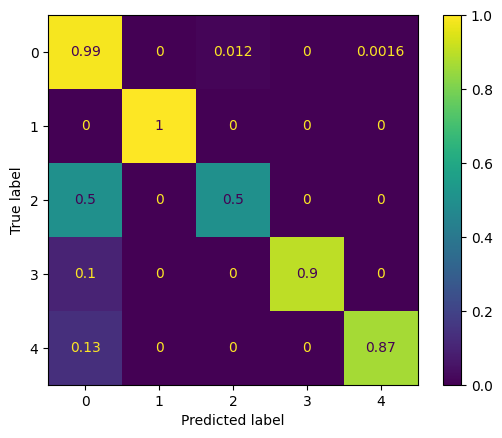

In [35]:
#criando e treinando o XGBoost baseline
estimador_xgb = XGBClassifier(random_state=42)
estimador_xgb.fit(X_sm, y_sm)
y_pred_xgb = estimador_xgb.predict(X_test_scaled)

print(classification_report(y_test, y_pred_xgb))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb, normalize='true')).plot()

In [36]:
espaco_hiper = {
    'learning_rate': [0.01, 0.1, 0.15, 0.2],
    'alpha': [0.01, 0.3, 0.8, 1],
    'colsample_bytree': [0.1, 0.4, 0.8, 1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

randomized_rfc = RandomizedSearchCV(
    estimator=estimador_xgb,
    param_distributions=espaco_hiper,
    cv=cv,
    verbose=3,
    scoring = 'f1_macro',
    random_state=42
)

randomized_rfc.fit(X_sm, y_sm)
randomized_rfc.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END alpha=1, colsample_bytree=0.4, learning_rate=0.01;, score=0.986 total time=   3.9s
[CV 2/5] END alpha=1, colsample_bytree=0.4, learning_rate=0.01;, score=0.989 total time=   3.6s
[CV 3/5] END alpha=1, colsample_bytree=0.4, learning_rate=0.01;, score=0.988 total time=   3.8s
[CV 4/5] END alpha=1, colsample_bytree=0.4, learning_rate=0.01;, score=0.987 total time=   3.8s
[CV 5/5] END alpha=1, colsample_bytree=0.4, learning_rate=0.01;, score=0.988 total time=   8.0s
[CV 1/5] END alpha=1, colsample_bytree=0.8, learning_rate=0.15;, score=0.995 total time=   5.3s
[CV 2/5] END alpha=1, colsample_bytree=0.8, learning_rate=0.15;, score=0.997 total time=   4.1s
[CV 3/5] END alpha=1, colsample_bytree=0.8, learning_rate=0.15;, score=0.997 total time=   4.5s
[CV 4/5] END alpha=1, colsample_bytree=0.8, learning_rate=0.15;, score=0.996 total time=   4.0s
[CV 5/5] END alpha=1, colsample_bytree=0.8, learning_rate=0.15;, score=0.99

{'learning_rate': 0.15, 'colsample_bytree': 0.8, 'alpha': 1}

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1287
           1       1.00      1.00      1.00        13
           2       0.12      0.50      0.19         6
           3       1.00      0.90      0.95        10
           4       0.93      0.87      0.90        15

    accuracy                           0.98      1331
   macro avg       0.81      0.85      0.80      1331
weighted avg       0.99      0.98      0.98      1331



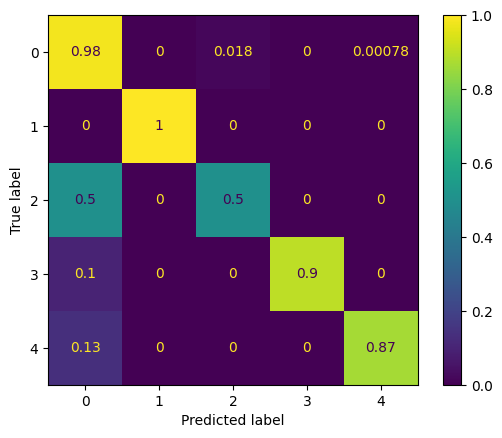

In [37]:
#treinando o estimador com os melhores parâmetros
estimador_xgb_best = XGBClassifier(random_state=42, learning_rate= 0.15, colsample_bytree=0.8, alpha=1)
estimador_xgb_best.fit(X_sm, y_sm)
y_pred_xgb = estimador_xgb_best.predict(X_test_scaled)

print(classification_report(y_test, y_pred_xgb))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb, normalize='true')).plot()

## 6. Comparação e escolha do modelo

Vamos selecionar os modelos após passarem pelo RandomSearch e compará-los:


<img src="imgs/resultados.png" width=1200>

Pelas matrizes acima, torna-se claro que o melhor modelo para este problema é o RandomForest. Ele apresenta as melhores métricas de precisão e recall, e a melhor matriz de confusão. <br/>
Além de prever corretamente todas as vezes que alguma falha acontece, quando o modelo comete erro ele está sendo 'conservador'. Com 'conservador', quero dizer que ele diz que há uma falha quando não há, o que pensando em predição de falhas, é melhor do que não predizer uma falha quando ela acontece! <br/>
Assim, o modelo escolhido é o RandomForest otimizado.

O estimador **RandomForest** tem performance excelente e não exige normalização de features, apesar de ter sido feita. Assim, num futuro modelo poderiamos observar como ele performa sem o passo de normalizações, que neste notebook foi realizado principalmente por conta do modelo KNN. Como um contra, o modelo gerado pelo RandomForest é difícil de ser interpretado por humanos.

## 7. Treinamento do modelo final

Agora que já temos o modelo escolhido, vamos retreiná-lo com todos os dados disponíveis para teste. Após isso, faremos a predição para os dados a serem entregues, sem esquecer de antes fazer todas as alterações necessárias nestes dados.

Devemos lembrar que é provavel que tenhamos uma performance pior do que a prevista acima, pois no dataset de treino teremos os "Random Failures", que o nosso modelo não consegue prever!

In [38]:
# fazendo a divisão do dataset
X = df_falhas.drop(columns=['failure_type'])
y = df_falhas['failure_type']

# fazendo o scale das features
mms = MinMaxScaler()
rs = RobustScaler()
ss = StandardScaler()

mms_columns = ['tool_wear_min', 'is_time_for_change','temp_dif','power', 'overstrain']
rs_columns = ['rotational_speed_rpm', 'torque_nm']
ss_columns = ['air_temperature_k', 'process_temperature_k']

features_scaled_mms = pd.DataFrame(mms.fit_transform(X[mms_columns]))
features_scaled_rs = pd.DataFrame(rs.fit_transform(X[rs_columns]))
features_scaled_ss = pd.DataFrame(ss.fit_transform(X[ss_columns]))

In [39]:
# reconstruindo o dataset
X_scaled = pd.concat([features_scaled_mms,features_scaled_rs,features_scaled_ss], axis=1)
X_scaled = pd.concat([X_scaled,pd.DataFrame(X['type']).set_index(X_scaled.index)], axis = 1,ignore_index=True)
X_scaled.columns = ['tool_wear_min', 'is_time_for_change','temp_dif','power', 'overstrain', 'rotational_speed_rpm', 'torque_nm', 'air_temperature_k', 'process_temperature_k', 'type']

In [40]:
# fazendo o balanceamento do dataset
sm = SMOTE(random_state=42)
X_final, y_final = sm.fit_resample(X_scaled, y)


print(f"Treino (antes): {X_scaled.shape}")
print(f"Treino: {X_final.shape}")


Treino (antes): (6655, 10)
Treino: (32175, 10)


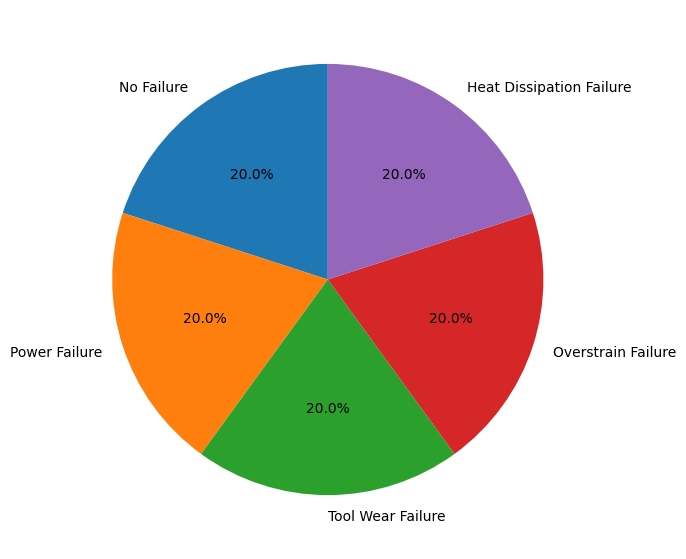

In [41]:
#conferindo o balanceamento das classes
df_final = pd.concat([X_final, y_final], axis=1)
df_final.columns = ['tool_wear_min', 'is_time_for_change','temp_dif','power', 'overstrain', 'rotational_speed_rpm', 'torque_nm', 'air_temperature_k', 'process_temperature_k', 'type', 'failure_type']
plt.figure(figsize = (7, 7))
plt.pie(x=df_final.failure_type.value_counts(), labels={'No Failure':0, 'Power Failure':1, 'Tool Wear Failure':2, 'Overstrain Failure':3, 'Heat Dissipation Failure':4}, autopct='%1.1f%%', startangle=90)
plt.show()

In [42]:
#treinando o modelo final
estimador_final = RandomForestClassifier(random_state=42, n_estimators=100, max_leaf_nodes=30, max_depth=15, criterion='log_loss')
estimador_final.fit(X_final, y_final)

RandomForestClassifier(criterion='log_loss', max_depth=15, max_leaf_nodes=30,
                       random_state=42)

In [43]:
# Agora vamos importar o dataset de teste
df_teste = pd.read_csv('data/desafio_manutencao_preditiva_teste.csv')
display(df_teste.head())
print(f'A tabela tem {df_teste.shape[1]} colunas e {df_teste.shape[0]} registros.')

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,446,L47625,L,297.5,308.6,1793,26.7,70
1,7076,L54255,L,300.7,310.5,1536,47.4,192
2,1191,L48370,L,297.2,308.4,1460,42.1,41
3,2618,L49797,L,299.4,309.1,1670,35.9,68
4,5067,L52246,L,304.1,313.1,1550,30.9,9


A tabela tem 8 colunas e 3333 registros.


In [44]:
# deletaremos as colunas desnecessárias
df_teste.drop(["udi", "product_id"], axis = 1, inplace=True)

# tornaremos o type em uma feature numérica
df_teste.type.replace({'L':0, 'M':1, 'H':2}, inplace=True)

# criaremos as features iguais as anteriores
df_teste['is_time_for_change'] = df_teste.apply(lambda x: 1 if (x.tool_wear_min > 200 and x.tool_wear_min < 240) else 0 ,axis=1)
df_teste['temp_dif'] = df_teste['process_temperature_k'] - df_teste['air_temperature_k']
df_teste['power'] = df_teste['torque_nm'] * df_teste['rotational_speed_rpm']
df_teste['overstrain'] = df_teste['torque_nm'] * df_teste['tool_wear_min']

df_teste.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,is_time_for_change,temp_dif,power,overstrain
0,0,297.5,308.6,1793,26.7,70,0,11.1,47873.1,1869.0
1,0,300.7,310.5,1536,47.4,192,0,9.8,72806.4,9100.8
2,0,297.2,308.4,1460,42.1,41,0,11.2,61466.0,1726.1
3,0,299.4,309.1,1670,35.9,68,0,9.7,59953.0,2441.2
4,0,304.1,313.1,1550,30.9,9,0,9.0,47895.0,278.1


In [45]:
# Por fim, vamos fazer os mesmos scales feitos no conjunto de treino
features_scaled_mms = pd.DataFrame(mms.transform(df_teste[mms_columns]))
features_scaled_rs = pd.DataFrame(rs.transform(df_teste[rs_columns]))
features_scaled_ss = pd.DataFrame(ss.transform(df_teste[ss_columns]))

# reconstruindo o dataset de teste
df_teste_scaled = pd.concat([features_scaled_mms,features_scaled_rs,features_scaled_ss], axis=1)
df_teste_scaled = pd.concat([df_teste_scaled,pd.DataFrame(df_teste['type']).set_index(df_teste_scaled.index)], axis = 1,ignore_index=True)
df_teste_scaled.columns = ['tool_wear_min', 'is_time_for_change','temp_dif','power', 'overstrain', 'rotational_speed_rpm', 'torque_nm', 'air_temperature_k', 'process_temperature_k', 'type']

In [46]:
y_pred_final = pd.DataFrame(estimador_final.predict(df_teste_scaled))
dict_falhas_reverso = {0:'No Failure', 1:'Power Failure', 2:'Tool Wear Failure', 3:'Overstrain Failure', 4:'Heat Dissipation Failure'}
y_pred_final = y_pred_final.replace(dict_falhas_reverso)

In [47]:
# Configurando e exportando envio final
y_pred_final.columns = ['predictedValues']
y_pred_final.to_csv('predicted.csv', index_label='rowNumber')

Feito! Os resultados preditos estão no arquivo *'predicted.csv'*.
